# [IRSN](https://www.irsn.fr/FR/Pages/Home.aspx)
# Project: Teleray Alert  
*Damon Cecilia (IRSN/D3NSI), Chuzel Sonia (IRSN/LTD), Vidal Romain (IRSN/LTD), Alt Aljoscha (IRSN/Grenoble INP Ense3)*  

# Introduction  


The [teleray project](https://lsbb.cnrs.fr/recherche/onde-environnement-radiatif/telerayirsn/) was launched by the necessity to monitor in real time the elevation of ambiant radioactivity. This system takes the shape of more than 400 sensor placed on the french soil, thus allowing the surveillance of natural and man made radiological activities.  
  
A team of experts insures the watch and acquitment of radiological alerts 24/7 on the entire network. This tremendous work, with up to 1000 alerts per month, motivated this research to integrate artificial intelligence to automatize the identification of alerts sources hence facilitating the acquitment.  
In this context, the data to develop this AI comes from several sources:
   * [Ambiant dose rate](https://www.radiation-dosimetry.org/what-is-ambient-dose-equivalent-h10-definition/) from 150 sensors with 1 measure/10mns 
   * Internal temperature of the sensors, 1 measure/10mns
   * Rain from [Météo France](https://meteofrance.com/), 1 measure/h
   * Pressure from Météo France, 1 measure/h
   * Temperature from Météo France, 1 measure/h
   * Simulated Gamma from [BMCA](https://www.irsn.fr/FR/Larecherche/Organisation/equipes/radioprotection-homme/BMCA/Pages/bureau-modelisation-transferts-environnement-etude-consequences-accidents.aspx#.YN12Qbtxc2w),  1 measure/h   [ [1](#Link1) ]
   * Environment for 135 of the sensors 
   * Sensors clusters defined by the experts for 109 sensors 
   
To sum up the objective: Classification of radiological events using the data listed above 

In [2]:
#Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Data Exploration 

## Loading the data 

In [3]:
events= pickle.load(open('/projets/teleray_alert/data/Fichiers 2017-2020/dataFrames/train_events.pickle', 'rb'))
time_series= pickle.load(open('/projets/teleray_alert/data/Fichiers 2017-2020/dataFrames/train_time_series.pickle', 'rb'))

The data is separated in two pandas dataframes:
* events containing at each line metadata about the event 
* time_series containing the time series associated to each event, the column key refering to events.index 

Events contains:
   * IdIRSN: Sensor ID 
   * Label: Classfication output 
   * Date_start/Date_end: Start/End time of the event
   * Longitude/Latitude/Altitude: Sensor position
   * Obstacle: Presence or not of an obstacle near the sensor 
   * CrankedArm/Rooftop/BuriedBase/Tripod: Booleans indicating if the sensor is placed with this method 
   * Cluster: If given, sensor group to which belongs the sensor designed by IdIRSN 

In [4]:
events.head()

,IdIRSN,Label,Date_start,Date_end,Longitude,Latitude,Altitude,Obstacle,CrankedArm,Rooftop,BuriedBase,Tripod,Cluster
0,1029,Weather,2017-06-24 15:40:00,2017-06-25 02:00:00,4.894182,44.935719,130.0,0,True,False,False,False,NaN
1,1029,ElectronicPeak3,2018-03-30 11:20:00,2018-03-30 18:40:00,4.894182,44.935719,130.0,0,True,False,False,False,NaN
2,1446,Weather,2018-07-20 14:50:00,2018-07-20 23:10:00,5.044493,45.692329,249.0,1,False,False,False,True,BUGEY - CREYS MALVILLE
3,1446,Weather,2018-08-22 18:40:00,2018-08-23 01:00:00,5.044493,45.692329,249.0,1,False,False,False,True,BUGEY - CREYS MALVILLE
4,1446,Weather,2018-10-29 11:00:00,2018-10-30 08:50:00,5.044493,45.692329,249.0,1,False,False,False,True,BUGEY - CREYS MALVILLE


Time_series contains time series with measures each 10mns: 
   * Key_event: index of the event, in dataframe events, to which the measure belongs
   * DoseRate: time series with a measure each 10mns
   * SimulatedGamma/Precipitation/InternalTemperaure/Pressure/Temperature/ZonalWind: time series resampled /10mns, originaly sampled at 1 measure/h
   * Date: date of the measurement 

In [5]:
time_series.head()

,Key_event,DoseRate,SimulatedGamma,Precipitation,InternalTemperature,Pressure,Temperature,ZonalWind,Date
0,0,64.720001,2.379895,0.004395,NaN,36319.777344,303.381073,3.325241,2017-06-24 15:40:00
1,0,66.440002,2.379895,0.004395,39.5,36319.777344,303.381073,3.325241,2017-06-24 15:50:00
2,0,68.610001,2.150784,0.000489,39.0,100340.179688,303.591797,3.748219,2017-06-24 16:00:00
3,0,68.809998,2.150784,0.000489,NaN,100340.179688,303.591797,3.748219,2017-06-24 16:10:00
4,0,72.099998,2.150784,0.000489,NaN,100340.179688,303.591797,3.748219,2017-06-24 16:20:00


### Proportion of output labels 

Number of samples: 261


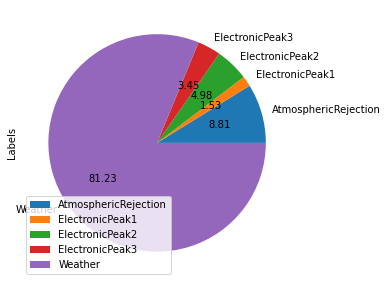

In [7]:
print('Number of samples: %s' % events.shape[0])
events.rename(columns={'IdIRSN': 'Labels'}).groupby('Label').count().plot(
    y='Labels', kind='pie', autopct='%.2f', figsize=(5, 5));

### Events examples 

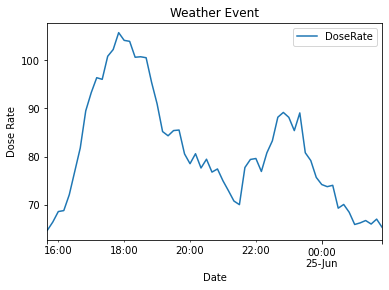

In [8]:
time_series[time_series.Key_event==0].plot(y='DoseRate', x='Date', title='Weather Event', ylabel='Dose Rate');

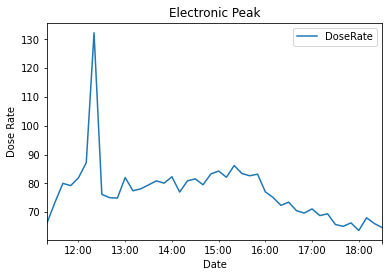

In [9]:
time_series[time_series.Key_event==1].plot(y='DoseRate', x='Date', title='Electronic Peak', ylabel='Dose Rate');

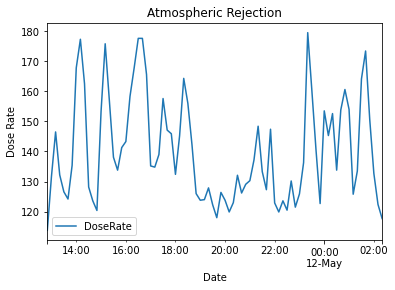

In [10]:
time_series[time_series.Key_event==422].plot(y='DoseRate', x='Date', title='Atmospheric Rejection', ylabel='Dose Rate');

# Classification problem 

Each submission will contain two classes, saved in two different files:  
* The *Feature Extractor* in feature_extractor.py to extract features for the classification 
* The *Classifier* in classifier.py to classify the radiological events

The first step is a feature extractor, taking the raw time series and turning them in vector of statistical properties.

In [ ]:
# file submissions/starting_kit/feature_extractor.py

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction.settings import from_columns

class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        extracted_features = extract_features(X_df, column_id="Cle")
        #Imputation to remove unusable features creating nans 
        extracted_features=impute(extracted_features)  
        #Calculation of p_values to evaluate features usefullness
        df_p_values=calculate_relevance_table(extracted_features, y, ml_task='classification')
        self.df_p_value= df_p_values
        #Deleting irrelevant features according to p_values
        extracted_features=extracted_features.drop(columns=df_p_values_new[df_p_values_new.relevant==0].index.values)
        #Dictionnary containing features and corresponding parameters 
        self.features=  from_columns(extracted_features.columns)
        
    def transform(self, X_df):
        df_features= extract_features(X_df, column_id="Cle", default_fc_parameters=self.features)
        return df_features

*Overwriting submissions/starting_kit/features_extractor.py*  
The classifier implements a classifier of the scikit-learn template. The default is a random forest.

In [ ]:
# file submissions/starting_kit/classifier.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.n_estimators = 100
        self.clf = Pipeline([
            ('clf', RandomForestClassifier(
                n_estimators=self.n_estimators, random_state=2))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

*Overwriting submissions/starting_kit/classifier.py*  


# The scores

This classification problem is evaluated through two scores taking into account class imbalance: 
* Weighted AUC 
* [Balanced Accuracy](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/score_types/balanced_accuracy.py)

The weighted AUC is calculated using the [scikit-learn library](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), computing the average AUC over the labels weighted by support to take into account class imbalance (the class is shown below). 

In [ ]:
class weighted_ROCAUC(BaseScoreType):
    is_lower_the_better = False
    minimum = 0.0
    maximum = 1.0

    def __init__(self, name='weighted_roc_auc', precision=2):
        self.name = name
        self.precision = precision

    def score_function(self, ground_truths, predictions):
        """
            Weighted average AUC:
            Calculate metrics for each label, and find their average, weighted by support. 
        """
        y_proba = predictions.y_pred #shape (n_samples, n_classes)
        y_true_proba = ground_truths.y_pred_label_index #shape (n_samples, 1)
        y_true_proba= label_binarize(y_true_proba, classes=np.unique(y_true_proba)) #shape (n_samples, n_classes)
        self.check_y_pred_dimensions(y_true_proba, y_proba)
        return self.__call__(y_true_proba, y_proba)

    def __call__(self, y_true_proba, y_proba):
        return roc_auc_score(y_true_proba, y_proba, average='weigthed')

# Ressources 

[1]<a class="anchor" id="Link1"></a> https://meetingorganizer.copernicus.org/EGU21/EGU21-9081.html